In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score
#import torch.nn as nn

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000, hidden_layer_sizes=(10,), eps=1e-6):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_layers = 1 + len(hidden_layer_sizes)
        self.eps = eps
        self.parameters = None  # W and b
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x, hidden_layers, n_y):
        np.random.seed(1)
        
        t = 0
        t = "asdfds"
        
        W_arr = list()
        b_arr = list()
        self.dW = list()
        self.db = list()
        
        layers = list(hidden_layers)
        layers.insert(0, n_x)
        layers.append(n_y)
        layers = tuple(layers)
        
        for i in range(1, self.n_layers+1):
            W = np.random.randn(layers[i], layers[i-1]) * 0.01
            b = np.zeros((layers[i], 1))
            dW = np.zeros((layers[i], layers[i-1]))
            db = np.zeros((layers[i], 1))
            
            W_arr.append(W)
            b_arr.append(b)
            self.dW.append(dW)
            self.db.append(db)
        
        self.parameters = {"W": W_arr, "b": b_arr}
  

    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]
        
        Z = list()
        A = list()
        
        Z.append(np.dot(W[0], X) + b[0])
        A.append(self.__sigmoid(Z[0]))

        for i in range(1, self.n_layers):
            Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
            
        cache = (W, b, Z, A)
        return A[-1], cache
 

    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J

    
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dZ = [None for i in range(self.n_layers)]
        dW = [None for i in range(self.n_layers)]
        db = [None for i in range(self.n_layers)]
        dA = [None for i in range(self.n_layers)]
        
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        dA[-1] = np.dot(W[-1].T, dZ[-1])
        
        for i in range(self.n_layers-1, 1, -1):
            dZ[i-1] = np.multiply(dA[i], np.multiply(A[i-1], 1 - A[i-1]))
            dW[i-1] = 1. / m * np.dot(dZ[i-1], A[i-2].T)
            db[i-1] = 1. / m * np.sum(dZ[i-1], axis = 1, keepdims = True)
            dA[i-1] = np.dot(W[i-1].T, dZ[i-1])
            

        dZ[0] = np.multiply(dA[1], np.multiply(A[0], 1 - A[0]))
        dA[0] = np.dot(W[0].T, dZ[0])
        
        dW[0] = 1. / m * np.dot(dZ[0], X.T)
        db[0] = 1. / m * np.sum(dZ[0], axis = 1, keepdims = True)
        

        grads = {"dZ": dZ, "dW": dW, "db": db}
        return grads
    
        
    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]
        
        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.n_layers):
            W[i] = W[i] - self.learning_rate * dW[i]
            b[i] = b[i] - self.learning_rate * db[i]
        
        self.parameters = {"W": W, "b": b}

        
    def fit(self, X_vert, Y_vert, n_iters_stop = 5, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
                
        costs = []
        costs_history = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        n_y = Y.shape[0]
        
        self.__initialize_parameters(n_x, self.hidden_layer_sizes, n_y)
        iters_to_break = 0;

        for i in range(self.num_iter):
            self.iterations = i
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)
            costs_history.append(cost)
            
            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)

            
            if i >= 1 and (costs_history[-1] - costs_history[-2]) >= 0:
                iters_to_break = iters_to_break + 1
                if iters_to_break == n_iters_stop:
                    break
            else:
                iters_to_break = 0;
                
        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()

            
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)

In [5]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


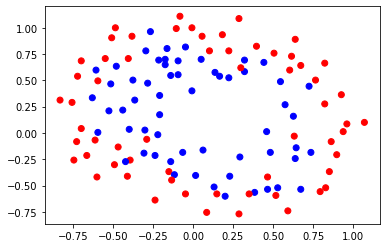

In [6]:
plot_data(X, Y)

In [7]:
cls = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 4000, hidden_layer_sizes=(20,), eps=1e-6)

0-th iteration: 0.6933754913074256
1000-th iteration: 0.6898887572536652
2000-th iteration: 0.6035741004857593
3000-th iteration: 0.4082928240168438


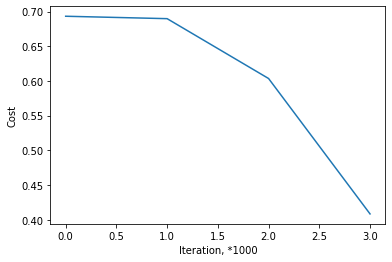

In [8]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)), n_iters_stop=5)

In [9]:
print(cls.parameters)

{'W': [array([[ 8.85350221e-01, -7.67354736e-01],
       [-2.85542768e-01,  1.68040835e+00],
       [ 2.69187558e-01, -3.33499854e+00],
       [ 4.30430464e-02, -8.54384623e-02],
       [ 2.69618552e-03, -1.26549519e-01],
       [ 2.02829105e+00,  1.75775673e+00],
       [ 3.17507370e-01,  1.18337119e-01],
       [ 9.66992561e-01, -5.18489815e-02],
       [ 1.11473301e-01, -4.34282335e-02],
       [ 1.24256919e+00, -5.51762001e-01],
       [-2.55188268e-02,  1.73072148e+00],
       [-2.57324029e-01, -6.09394050e-01],
       [ 9.93064986e-01,  1.53891429e-01],
       [-1.07929276e+00, -1.77387660e-02],
       [ 2.99281744e-01,  9.86828457e-02],
       [ 1.33900244e+00,  2.83118077e-01],
       [ 1.52714196e-01,  4.07466352e-02],
       [ 1.75853909e-01,  9.15608495e-02],
       [ 1.03159900e+00,  5.37051030e-01],
       [ 3.72815779e-02, -9.99929142e-02]]), array([[ 2.17273272, -4.15886638, -4.48843501, -0.86266388, -0.98367149,
        -8.86518308, -0.34859616,  0.86846916, -0.75128858

In [10]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[5.72836213e-01, 4.27163787e-01],
       [7.88658961e-01, 2.11341039e-01],
       [3.58044541e-01, 6.41955459e-01],
       [1.53321405e-01, 8.46678595e-01],
       [1.02157470e-01, 8.97842530e-01],
       [8.46976341e-01, 1.53023659e-01],
       [5.07451004e-02, 9.49254900e-01],
       [2.63875337e-01, 7.36124663e-01],
       [7.26038491e-01, 2.73961509e-01],
       [9.34668228e-01, 6.53317720e-02],
       [9.63887519e-01, 3.61124806e-02],
       [3.17810729e-01, 6.82189271e-01],
       [2.53242927e-01, 7.46757073e-01],
       [1.26567307e-01, 8.73432693e-01],
       [7.76781035e-01, 2.23218965e-01],
       [2.18585177e-01, 7.81414823e-01],
       [6.06118305e-01, 3.93881695e-01],
       [8.34845501e-01, 1.65154499e-01],
       [7.17586965e-01, 2.82413035e-01],
       [2.17261296e-01, 7.82738704e-01],
       [9.94531769e-01, 5.46823051e-03],
       [8.56075541e-01, 1.43924459e-01],
       [8.69144234e-01, 1.30855766e-01],
       [6.14926622e-02, 9.38507338e-01],
       [2.581528

In [11]:
Y_hat = cls.predict(X)
Y_hat

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0])

In [12]:
accuracy_score(Y, Y_hat)

0.864406779661017

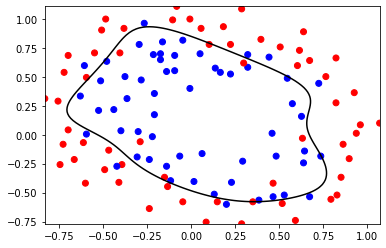

In [13]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [14]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [15]:
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(20,), learning_rate_init=0.01, max_iter=10000,
              solver='sgd')

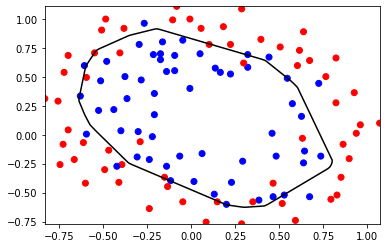

In [16]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [17]:
accuracy_score(Y, clf.predict(X))

0.8389830508474576

In [18]:
data_columns = ["exam1", "exam2"]
target_column = "submitted"
df = pd.read_csv("sats.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(100, 2), y=(100,)


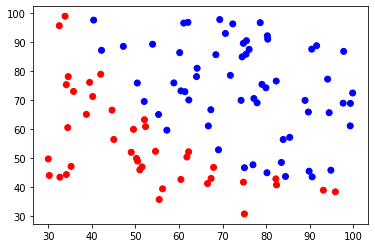

In [19]:
plot_data(X, Y)

In [20]:
cls = NeuralNet(normalize = True, learning_rate = 0.6, num_iter = 4000, hidden_layer_sizes=(100,), eps=1e-6)

0-th iteration: 0.6926602601273588
1000-th iteration: 0.6693992175520981
2000-th iteration: 0.4449734789939521
3000-th iteration: 0.22987140085697375


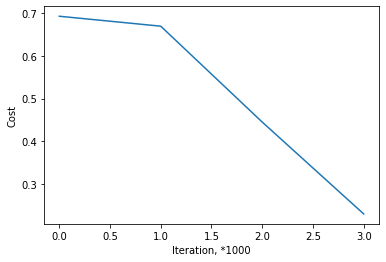

In [21]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)), n_iters_stop=5)

In [22]:
print(cls.parameters)

{'W': [array([[ 0.39176375,  0.32923101],
       [-0.52948543, -0.47187932],
       [-1.70467478, -1.53154089],
       [ 2.72530071,  2.39472441],
       [-1.26635087, -1.12017672],
       [-2.23240952, -1.99948349],
       [-2.33959438, -2.06075052],
       [-0.79559501, -0.72217552],
       [-2.04773233, -1.80973163],
       [ 2.28980803,  2.03877932],
       [-0.39993695, -0.33027638],
       [-0.2015118 , -0.1797882 ],
       [ 1.14501382,  1.00555756],
       [-1.47363537, -1.30525625],
       [-1.04948374, -0.91610772],
       [-0.11730426, -0.0994801 ],
       [-0.67628678, -0.59753415],
       [-1.04018435, -0.90959996],
       [ 0.4705498 ,  0.43208358],
       [ 1.98930248,  1.76086595],
       [ 0.57150219,  0.50281884],
       [ 1.01781761,  0.92937508],
       [ 0.89669442,  0.79251792],
       [ 1.77293897,  1.59513105],
       [-0.63165939, -0.55114705],
       [ 2.24910658,  1.99183406],
       [-1.88155042, -1.64894555],
       [ 0.00918288,  0.017759  ],
       [ 0.62

In [23]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[1.42975504e-01, 8.57024496e-01],
       [4.60691772e-04, 9.99539308e-01],
       [8.41521061e-02, 9.15847894e-01],
       [9.72910404e-01, 2.70895962e-02],
       [9.92542872e-01, 7.45712821e-03],
       [3.00377556e-02, 9.69962244e-01],
       [9.95050241e-01, 4.94975940e-03],
       [4.47647546e-01, 5.52352454e-01],
       [9.98134777e-01, 1.86522281e-03],
       [6.95706245e-01, 3.04293755e-01],
       [8.62086094e-01, 1.37913906e-01],
       [6.41640395e-02, 9.35835961e-01],
       [9.96265007e-01, 3.73499307e-03],
       [9.98882652e-01, 1.11734807e-03],
       [2.11826521e-01, 7.88173479e-01],
       [9.54255538e-01, 4.57444621e-02],
       [4.49340565e-01, 5.50659435e-01],
       [2.10435493e-01, 7.89564507e-01],
       [9.98105497e-01, 1.89450328e-03],
       [5.64894579e-01, 4.35105421e-01],
       [1.18363184e-01, 8.81636816e-01],
       [9.94012681e-01, 5.98731874e-03],
       [2.28186589e-02, 9.77181341e-01],
       [8.86922976e-04, 9.99113077e-01],
       [9.765765

In [24]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1])

In [25]:
accuracy_score(Y, Y_hat)

0.89

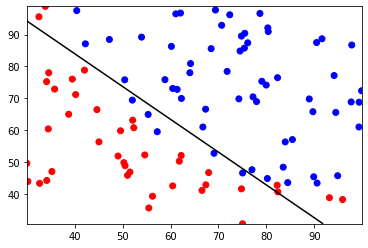

In [26]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [27]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (800,), max_iter = 10000, activation = 'tanh', solver = 'sgd', learning_rate_init = 0.0005, learning_rate = 'constant')

In [28]:
clf.fit(X, Y)

MLPClassifier(activation='tanh', hidden_layer_sizes=(800,),
              learning_rate_init=0.0005, max_iter=10000, solver='sgd')

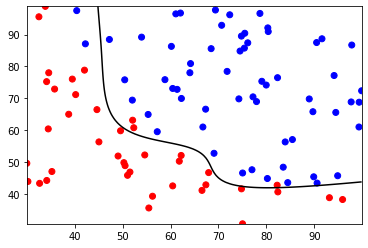

In [29]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [30]:
accuracy_score(Y, clf.predict(X))

0.95